- Check batch data :check:
- appropriate pad masking with goal indexing :check:
- develop model to forward on batch data :check:
- design evaluator :check: just needs to make sure act taker fits interface
- develop model to retrieve acts :check:
- design trainer :check:
- modify experiment to include transformer_idm
    - more args
    - add state_dim, act_dim 
    - test it 

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import einops
from decision_transformer.models.gated_fusion import GatedFusion, create_modified_padding_mask, generate_square_subsequent_mask
from decision_transformer.models.transformer_idm import TransformerIDM
%load_ext autoreload
%autoreload 2

c:\Users\msmic\Documents\code\rl\carla\rl_ad\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [186]:
env_name = "hopper"
dataset = "medium-replay"
with open(f"data/{env_name}-{dataset}-v2.pkl", 'rb') as fp:
    trajectories = pickle.load(fp)
states, traj_lens, returns = [], [], []
delayed=True
for path in trajectories:
    if delayed:  # delayed: all rewards moved to end of trajectory
        path['rewards'][-1] = path['rewards'].sum()
        path['rewards'][:-1] = 0.
    states.append(path['observations'])
    traj_lens.append(len(path['observations']))
    returns.append(path['rewards'].sum())
traj_lens, returns = np.array(traj_lens), np.array(returns)
states = np.concatenate(states, axis=0)
state_mean, state_std = np.mean(states, axis=0), np.std(states, axis=0) + 1e-6
state_dim, act_dim = states[0].shape[0], trajectories[0]['actions'][0].shape[0]
num_timesteps = sum(traj_lens)
max_ep_len = 1000
scale = 1000.0 # scale rewards by this factor
K = 20 # max sequence length
sorted_inds = np.argsort(returns)  # lowest to highest
num_trajectories = 1
timesteps = traj_lens[sorted_inds[-1]]
device='cpu'
ind = len(trajectories) - 2
while ind >= 0 and timesteps + traj_lens[sorted_inds[ind]] <= num_timesteps:
    timesteps += traj_lens[sorted_inds[ind]]
    num_trajectories += 1
    ind -= 1
sorted_inds = sorted_inds[-num_trajectories:]

# used to reweight sampling so we sample according to timesteps instead of trajectories
p_sample = traj_lens[sorted_inds] / sum(traj_lens[sorted_inds])

def discount_cumsum(x, gamma):
    discount_cumsum = np.zeros_like(x)
    discount_cumsum[-1] = x[-1]
    for t in reversed(range(x.shape[0]-1)):
        discount_cumsum[t] = x[t] + gamma * discount_cumsum[t+1]
    return discount_cumsum

def get_batch(batch_size=256, max_len=K):
        batch_inds = np.random.choice(
            np.arange(num_trajectories),
            size=batch_size,
            replace=True,
            p=p_sample,  # reweights so we sample according to timesteps
        )

        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        for i in range(batch_size):
            traj = trajectories[int(sorted_inds[batch_inds[i]])]
            si = random.randint(0, traj['rewards'].shape[0] - 1)

            # get sequences from dataset
            s.append(traj['observations'][si:si + max_len].reshape(1, -1, state_dim))
            a.append(traj['actions'][si:si + max_len].reshape(1, -1, act_dim))
            r.append(traj['rewards'][si:si + max_len].reshape(1, -1, 1))
            if 'terminals' in traj:
                d.append(traj['terminals'][si:si + max_len].reshape(1, -1))
            else:
                d.append(traj['dones'][si:si + max_len].reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= max_ep_len] = max_ep_len-1  # padding cutoff
            rtg.append(discount_cumsum(traj['rewards'][si:], gamma=1.)[:s[-1].shape[1] + 1].reshape(1, -1, 1))
            if rtg[-1].shape[1] <= s[-1].shape[1]:
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state + reward normalization
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, max_len - tlen, state_dim)), s[-1]], axis=1)
            s[-1] = (s[-1] - state_mean) / state_std
            a[-1] = np.concatenate([np.ones((1, max_len - tlen, act_dim)) * -10., a[-1]], axis=1)
            r[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, max_len - tlen, 1)), rtg[-1]], axis=1) / scale
            timesteps[-1] = np.concatenate([np.zeros((1, max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, max_len - tlen)), np.ones((1, tlen))], axis=1))

        s = torch.from_numpy(np.concatenate(s, axis=0)).to(dtype=torch.float32, device=device)
        a = torch.from_numpy(np.concatenate(a, axis=0)).to(dtype=torch.float32, device=device)
        r = torch.from_numpy(np.concatenate(r, axis=0)).to(dtype=torch.float32, device=device)
        d = torch.from_numpy(np.concatenate(d, axis=0)).to(dtype=torch.long, device=device)
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).to(dtype=torch.float32, device=device)
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).to(dtype=torch.long, device=device)
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).to(device=device)

        return s, a, r, d, rtg, timesteps, mask

In [187]:
traj_lengths = traj_lens
traj_lens.mean(), returns.mean()

(196.96227339539442, 467.30203)

Correlation: 0.9138373536202324
Mean Trajectory Length: 196.96227339539442, Std Trajectory Length: 195.15275753287645
Mean Returns: 467.3020324707031, Std Returns: 511.0256042480469
Covariance: 91179.89313194717


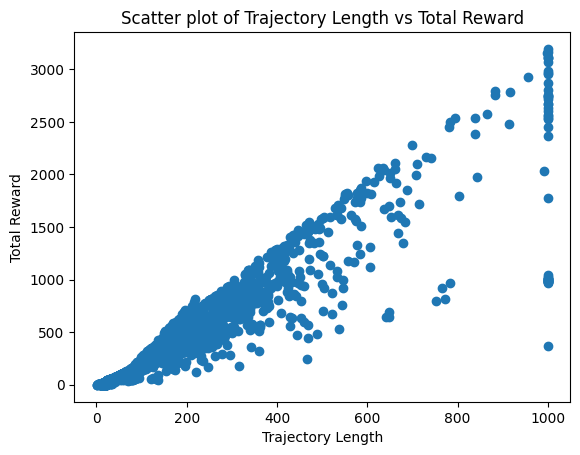

In [188]:
# Compute correlation
correlation = np.corrcoef(traj_lengths, returns)[0, 1]
print(f"Correlation: {correlation}")

# Compute mean and standard deviation
mean_traj_lengths = np.mean(traj_lengths)
std_traj_lengths = np.std(traj_lengths)
mean_returns = np.mean(returns)
std_returns = np.std(returns)

print(f"Mean Trajectory Length: {mean_traj_lengths}, Std Trajectory Length: {std_traj_lengths}")
print(f"Mean Returns: {mean_returns}, Std Returns: {std_returns}")

# Compute covariance
covariance = np.cov(traj_lengths, returns)[0, 1]
print(f"Covariance: {covariance}")

# Scatter plot
plt.scatter(traj_lengths, returns)
plt.xlabel("Trajectory Length")
plt.ylabel("Total Reward")
plt.title("Scatter plot of Trajectory Length vs Total Reward")
plt.show()

Mean Normalized Rewards: 2.036255345632188, Std Normalized Rewards: 0.8639036863302407


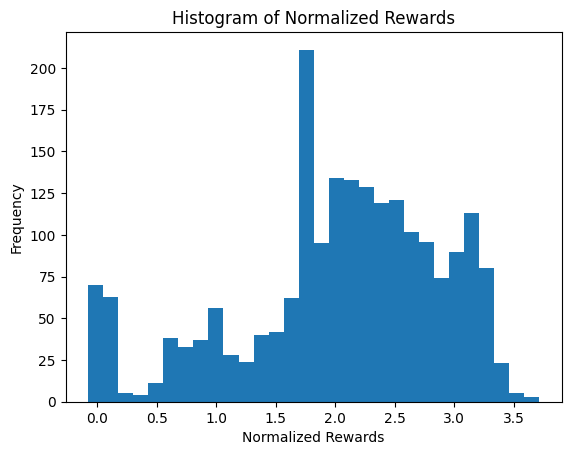

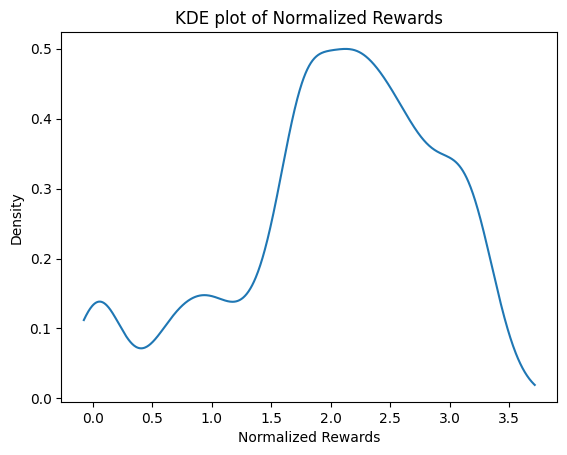

In [189]:
import numpy as np
import matplotlib.pyplot as plt

# Compute normalized rewards
normalized_rewards = returns / traj_lengths

# Compute mean and standard deviation
mean_normalized_rewards = np.mean(normalized_rewards)
std_normalized_rewards = np.std(normalized_rewards)

print(f"Mean Normalized Rewards: {mean_normalized_rewards}, Std Normalized Rewards: {std_normalized_rewards}")

# Histogram plot
plt.hist(normalized_rewards, bins=30)
plt.xlabel("Normalized Rewards")
plt.ylabel("Frequency")
plt.title("Histogram of Normalized Rewards")
plt.show()

# KDE plot
from scipy.stats import gaussian_kde

density = gaussian_kde(normalized_rewards)
x_vals = np.linspace(min(normalized_rewards), max(normalized_rewards), 1000)
y_vals = density(x_vals)

plt.plot(x_vals, y_vals)
plt.xlabel("Normalized Rewards")
plt.ylabel("Density")
plt.title("KDE plot of Normalized Rewards")
plt.show()

In [190]:
# Compute median, quartiles, and IQR
median_normalized_rewards = np.median(normalized_rewards)
q1_normalized_rewards = np.percentile(normalized_rewards, 25)
q3_normalized_rewards = np.percentile(normalized_rewards, 75)
iqr_normalized_rewards = q3_normalized_rewards - q1_normalized_rewards

print(f"Median Normalized Rewards: {median_normalized_rewards}")
print(f"Q1 Normalized Rewards: {q1_normalized_rewards}, Q3 Normalized Rewards: {q3_normalized_rewards}")
print(f"IQR Normalized Rewards: {iqr_normalized_rewards}")

Median Normalized Rewards: 2.1390107421875
Q1 Normalized Rewards: 1.6847943906430844, Q3 Normalized Rewards: 2.666671531787817
IQR Normalized Rewards: 0.9818771411447325


In [191]:
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=256, max_len=K)
s.shape, a.shape, r.shape, d.shape, rtg.shape, timesteps.shape, mask.shape

(torch.Size([256, 20, 11]),
 torch.Size([256, 20, 3]),
 torch.Size([256, 20, 1]),
 torch.Size([256, 20]),
 torch.Size([256, 21, 1]),
 torch.Size([256, 20]),
 torch.Size([256, 20]))

In [192]:
rtg[4]

tensor([[0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232],
        [0.1232]])

In [221]:
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=256, max_len=K)
s.shape, a.shape, r.shape, d.shape, rtg.shape, timesteps.shape, mask.shape

(torch.Size([256, 20, 11]),
 torch.Size([256, 20, 3]),
 torch.Size([256, 20, 1]),
 torch.Size([256, 20]),
 torch.Size([256, 21, 1]),
 torch.Size([256, 20]),
 torch.Size([256, 20]))

In [194]:
prop_edge_case = 0
masked_entries = 0
for i in range(256):
    if mask[i].sum() != K:
        print(i)
        masked_entries += K - mask[i].sum()
        prop_edge_case += 1
print(prop_edge_case / 256, masked_entries / prop_edge_case)

0
10
47
72
87
101
108
114
125
132
143
165
183
184
187
196
236
247
255
0.07421875 tensor(10.6316, dtype=torch.float64)


In [195]:
timesteps[192]

tensor([183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 201, 202])

In [196]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
args = dotdict(
    max_ep_len=1000,
    embed_dim=128,
    n_enc_layers=1,
    n_dec_layers=2,
    n_head=1,
    dropout=0.1,
    K=K,
    activation_function='relu',
    state_dim = state_dim,
    act_dim = act_dim,
)

transformer = nn.Transformer(d_model=args.embed_dim, nhead=args.n_head, num_encoder_layers=args.n_enc_layers, num_decoder_layers=args.n_dec_layers, 
                                   dim_feedforward=args.embed_dim*4, dropout=args.dropout, activation=args.activation_function)
embed_timestep = nn.Embedding(args.max_ep_len, args.embed_dim)
embed_return = nn.Linear(1, args.embed_dim)
embed_state = nn.Linear(state_dim, args.embed_dim)
embed_action = nn.Embedding(1, args.embed_dim)
goal_net = nn.Sequential(nn.Linear(args.embed_dim*2, args.embed_dim), 
                         nn.ReLU(), 
                         nn.Linear(128, 128),
                         nn.ReLU(),
                         nn.Linear(128, args.embed_dim))
gated_fusion = GatedFusion(args.n_head, args.embed_dim)
predict_action = nn.Sequential(nn.Linear(args.embed_dim, act_dim),
                               nn.Tanh())
sum(p.numel() for p in transformer.parameters() if p.requires_grad)


727936

In [197]:
decoder_layer = nn.TransformerDecoderLayer(d_model=args.embed_dim, nhead=args.n_head, dim_feedforward=args.embed_dim*4, dropout=args.dropout, activation=args.activation_function)
transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=args.n_dec_layers+1)
sum(p.numel() for p in transformer_decoder.parameters() if p.requires_grad)

793728

In [222]:
memory_key_padding_mask, pos, first_nonzero = create_modified_padding_mask(mask, K, device)
idx = 192
memory_key_padding_mask[idx], mask[idx], pos[idx],memory_key_padding_mask[idx][pos[idx]]

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         0., 0.], dtype=torch.float64),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.], dtype=torch.float64),
 tensor(15),
 tensor(1., dtype=torch.float64))

In [199]:
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=256, max_len=K)
n, t, d = s.shape
idxs = torch.arange(n, device=device)
memory_key_padding_mask, pos = create_modified_padding_mask(mask, K, device)
s_X = embed_state(s)
a_X = embed_action.weight.repeat(1, n, 1)
# rtg = rtg[:, 0] # delay -> all same
r_X = embed_return(rtg[:, 0])
g, ps = einops.pack((s_X[idxs, pos], r_X), 'n *')
timesteps = einops.rearrange(timesteps, 'n t -> t n')
time_embds = embed_timestep(timesteps)

g = goal_net(g)
s_X = gated_fusion(s_X, g)
s_X = einops.rearrange(s_X, 'n t d -> t n d')
s_X = s_X + time_embds
# pack goal into s_X, modify masks accordingly
s_X, ps = einops.pack((s_X, g), '* n d')
mask_pad = torch.ones((n,1), device=device)
memory_key_padding_mask, ps = einops.pack((memory_key_padding_mask, mask_pad), 'n *')


a_X = transformer(src=s_X, tgt=a_X, src_key_padding_mask=memory_key_padding_mask,
            tgt_key_padding_mask=None, memory_key_padding_mask=memory_key_padding_mask)
a_X = predict_action(a_X)

s_X.shape, a_X.shape, r_X.shape, mask.shape, memory_key_padding_mask.shape, g.shape

(torch.Size([21, 256, 128]),
 torch.Size([1, 256, 3]),
 torch.Size([256, 128]),
 torch.Size([256, 20]),
 torch.Size([256, 21]),
 torch.Size([256, 128]))

In [299]:
transformer_idm = TransformerIDM(11, 3, 1000,args)
transformer_idm.to(device)
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=256, max_len=K)
src_n_memory_key_padding_mask, pos, first_nonzero = create_modified_padding_mask(mask, K, device)
a_X = transformer_idm(s, a, r, rtg[:,:-1], timesteps, src_n_memory_key_padding_mask, pos=pos)
a_X.shape, sum(p.numel() for p in transformer_idm.parameters() if p.requires_grad)

(torch.Size([1, 256, 3]), 1024003)

In [201]:
transformer_ps = sum(p.numel() for p in transformer_idm.transformer.parameters() if p.requires_grad)
goal_net_ps = sum(p.numel() for p in transformer_idm.goal_net.parameters() if p.requires_grad)
gated_fusion_ps = sum(p.numel() for p in transformer_idm.gated_fusion.parameters() if p.requires_grad)
predict_action_ps = sum(p.numel() for p in transformer_idm.predict_action.parameters() if p.requires_grad)
time_embds_ps = sum(p.numel() for p in transformer_idm.embed_timestep.parameters() if p.requires_grad)
transformer_ps, goal_net_ps, gated_fusion_ps, predict_action_ps, time_embds_ps, transformer_ps+goal_net_ps+gated_fusion_ps+predict_action_ps+time_embds_ps

(727936, 65920, 99328, 387, 128000, 1021571)

In [33]:
# evaluation data placeholders
t = 30
s_eval = torch.rand(1, t, state_dim, device=device)
a_eval = torch.rand(1, t, act_dim, device=device)
r_eval = torch.rand(1, t, 1, device=device)
rtg_eval = torch.rand(1, t, 1, device=device)
timesteps_eval = torch.arange(t, device=device).reshape(1, t)

act = transformer_idm.get_action(s_eval, a_eval, r_eval, rtg_eval, timesteps_eval)
act

19


tensor([-0.3341, -0.1149,  0.0554], grad_fn=<SelectBackward0>)

In [34]:
# SequenceTrainerIDM 


In [36]:
a[idxs,pos].shape

torch.Size([256, 3])

In [204]:
mask, src_n_memory_key_padding_mask

(tensor([[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64),
 tensor([[1., 1., 1.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 1., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64))

In [263]:
mask = generate_square_subsequent_mask(K, device)
mask = einops.repeat(mask, 'n t -> b n t', b=256).clone()
idxs = torch.arange(K, device=device)
for i in range(256):
    mask[i, :, :first_nonzero[i]] = float('-inf')
    mask[i, :, pos[i]+1:] = float('-inf')
    mask[i, idxs, idxs] = 0 # set diagonal to 0 to avoid nan collapse

In [264]:
pos, first_nonzero

(tensor([18,  8,  7, 18,  2, 13, 13,  6, 19, 16, 17, 15,  2, 16, 15,  1, 14, 12,
          7, 11,  6, 18,  9,  4,  5, 10, 19,  0, 13,  2,  4,  1,  2, 13,  2,  1,
         18,  6, 16, 11, 18, 18,  4,  0, 13, 10,  9, 12,  5,  7, 14,  2,  6,  8,
          3, 11, 18,  5, 16,  5,  7, 12, 18, 11,  8,  0, 11,  2,  3,  2,  6, 19,
         17,  2,  4,  6, 16,  3, 13,  4,  2,  2, 13,  6, 11,  4, 15, 13,  9,  8,
         11,  3, 14,  2, 18,  6,  7, 15,  8, 19,  9,  6,  2, 16,  6, 16, 14,  2,
         12,  4,  5,  2, 15, 12,  9, 16,  0, 18, 11,  7,  0, 17, 17,  2, 16,  0,
          1,  3, 13, 15, 19,  7,  1,  6, 15, 17,  2,  3,  3,  8, 14, 13, 15, 14,
         12,  9, 18, 16, 17,  4, 16,  6,  1,  9, 11,  5,  2, 19,  8, 14,  1, 19,
          1, 17, 14, 15, 17, 16,  0,  9, 15,  7, 17,  4, 10,  6, 10,  7, 15, 15,
          6, 13, 18, 13,  9,  6, 19, 12, 15,  9,  3,  9, 15,  8, 18, 16,  4,  0,
         18,  0,  9, 13, 15,  3, 15,  1, 18, 16, 11, 19,  1,  7,  9,  8, 16, 19,
         10, 19,  0, 13, 11,

In [265]:
mask[0]

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -

In [266]:
mask_pack, ps = einops.pack((mask, mask), 'b n *')

torch.Size([256, 20, 20])

In [247]:
# make tensor of shape 10,10 filled with -inf
mask = torch.full((10,10), float('-inf'))

In [249]:
mask.to(torch.bool)

tensor([[-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]])

In [277]:
S = torch.rand(13,32,64)
A = torch.rand(13,32,64)
SA,ps = einops.pack((S,A), 't n *')
SA.shape, (SA[:,:, :64] == S).all(), (SA[:,:, 64:] == A).all()

(torch.Size([13, 32, 128]), tensor(True), tensor(True))

In [283]:
SA_interleaved = einops.rearrange(SA, 't n (d1 d2) -> (t d1) n d2', d1=2)
SA_interleaved.shape, (SA_interleaved[::2] == S).all(), (SA_interleaved[1::2] == A).all()
# (SA_interleaved[:,:,0,:] == S).all(), (SA_interleaved[:,:,1,:] == A).all()

(torch.Size([26, 32, 64]), tensor(True), tensor(True))

In [294]:
key_pad_mask = torch.randint(0,2,(7,13), device=device).to(torch.bool)
key_pad_mask_interleaved = einops.repeat(key_pad_mask, 'n t -> (n repeat) t', repeat=2)
key_pad_mask_interleaved = einops.rearrange(key_pad_mask_interleaved, '(n repeat) t -> n (repeat t)', repeat=2)

In [296]:
(key_pad_mask_interleaved[:,:13] == key_pad_mask).all(), (key_pad_mask_interleaved[:,13:] == key_pad_mask).all()

(tensor(True), tensor(True))

# Make 2d mask and ensure it gets same outputs as key_pad_mask

In [459]:
b_sz = 64
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=b_sz, max_len=K)
mask_org = mask.clone()
mask = einops.repeat(mask, 'n t -> (n repeat) t', repeat=3)
mask = einops.rearrange(mask, '(n repeat) t -> n (t repeat)', repeat=3)
mask_2d = torch.zeros((b_sz, K*3, K*3), device=device)
first_nonzero = mask.argmax(dim=1)
idxs = torch.arange(K, device=device)

for i in range(b_sz):
    mask_2d[i, :, :first_nonzero[i]] = float('-inf')
    # mask_2d[i, idxs, idxs] = 0 # set diagonal to 0 to avoid nan collapse

# flip 
mask = ~(mask.to(torch.bool))
mask.shape, mask_2d.shape

(torch.Size([64, 60]), torch.Size([64, 60, 60]))

In [473]:
def to_2d_mask(mask, repeats, device='cpu'):
    K = mask.shape[1]
    mask = einops.repeat(mask, 'n t -> (n repeat) t', repeat=3)
    mask = einops.rearrange(mask, '(n repeat) t -> n (t repeat)', repeat=3)
    mask_2d = generate_square_subsequent_mask(K*repeats, device=device)
    # mask_2d = torch.zeros(K*repeats, K*repeats, device=device)
    mask_2d = einops.repeat(mask_2d, 't1 t2 -> b t1 t2', b=mask.shape[0]).clone()
    first_nonzero = mask.argmax(dim=1)
    idxs = torch.arange(K*repeats, device=device)

    for i in range(mask.shape[0]):
        mask_2d[i, :, :first_nonzero[i]] = float('-inf')
        mask_2d[i, idxs, idxs] = 0 # set diagonal to 0 to avoid nan collapse
    
    return mask_2d

In [474]:
encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=1, dim_feedforward=256, dropout=0)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(K*3, b_sz, 64)

In [475]:
transformer_encoder.train()
out1 = transformer_encoder(src, src_key_padding_mask=mask)
mask_2d = to_2d_mask(mask_org, 3, device=device)
out2 = transformer_encoder(src, mask=mask_2d)
# out2 = transformer_encoder(src, src_key_padding_mask=mask)
(out1 == out2).all(), torch.isclose(out1, out2).all()

(tensor(True), tensor(True))

In [415]:
first_nonzero, first_nonzero.argmax(dim=0)

(tensor([ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0, 24,  0,  0,  0,  0]),
 tensor(59))

In [408]:
mask[21], mask_2d[21]

(tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([[-inf, -inf, -inf,  ..., 0., 0., 0.],
         [-inf, -inf, -inf,  ..., 0., 0., 0.],
         [-inf, -inf, -inf,  ..., 0., 0., 0.],
         ...,
         [-inf, -inf, -inf,  ..., 0., 0., 0.],
         [-inf, -inf, -inf,  ..., 0., 0., 0.],
         [-inf, -inf, -inf,  ..., 0., 0., 0.]]))

In [432]:
b_sz = 64
s, a, r, d, rtg, timesteps, mask = get_batch(batch_size=b_sz, max_len=K)
mask = einops.repeat(mask, 'n t -> (n repeat) t', repeat=3)
mask = einops.rearrange(mask, '(n repeat) t -> n (t repeat)', repeat=3)
mask_2d = generate_square_subsequent_mask(K*3, device=device)
mask_2d = einops.repeat(mask_2d, 't1 t2 -> b t1 t2', b=b_sz).clone()
first_nonzero = mask.argmax(dim=1)
idxs = torch.arange(K*3, device=device)

for i in range(b_sz):
    mask_2d[i, :, :first_nonzero[i]] = float('-inf')
    mask_2d[i, idxs, idxs] = 0 # set diagonal to 0 to avoid nan collapse

In [433]:
out1 = transformer_encoder(src, src_key_padding_mask=mask)
out2 = transformer_encoder(src, mask=mask_2d)
out1.isnan().any(), out2.isnan().any()

(tensor(False), tensor(False))

In [484]:
stacked_attention_mask = torch.stack(
    (mask_org, mask_org, mask_org), dim=1
).permute(0, 2, 1).reshape(b_sz, 3*K)
stacked_attention_mask = ~(stacked_attention_mask.to(torch.bool))

In [485]:
mask_org.shape, mask.shape, stacked_attention_mask.shape, (mask == stacked_attention_mask).all()

(torch.Size([64, 20]),
 torch.Size([64, 60]),
 torch.Size([64, 60]),
 tensor(True))

In [483]:
stacked_attention_mask

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], dtype=torch.float64)

In [ ]:
random.randint()

In [488]:
from decision_transformer.models.gated_fusion import to_2d_mask_idm_pos

In [510]:
mask_2d, pos = to_2d_mask_idm_pos(mask_org, 2, device=device)

In [511]:
mask_2d[0]

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [519]:
mask_org[pos[0]], mask_2d[0, 10:14]

(tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.], dtype=torch.float64),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
          -inf, -inf, -inf, -inf, -inf, -i

In [518]:
pos[0]

tensor(6)

In [4]:
dataset_path = f'data/hopper-medium-replay-v2.pkl'
with open(dataset_path, 'rb') as f:
    trajectories = pickle.load(f)

In [18]:
trajectories[1]['rewards'].shape

(33,)

In [6]:
# temporal consistency 
representations = torch.rand(32, 20, 64)
reps = einops.rearrange(representations, 'b (t t_window) d -> b t t_window d', t_window=2)
for i in range(20//2):
    print((representations[:,i*2:i*2+2] == reps[:,i]).all())
print(reps.shape)

tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
torch.Size([32, 10, 2, 64])


In [9]:
reps_ = einops.rearrange(reps, 'b t t_window d -> t_window (b t) d')
reps_.shape
for b_idx in range(32):
    for t_idx in range(10):
        if not(reps[b_idx, t_idx] == reps_[:,b_idx*10+t_idx]).all():
            print(b_idx, t_idx)

In [11]:
reps[:,-1,-1,:].shape

torch.Size([32, 64])

In [5]:
x = torch.rand(32, 20, 64)
# make tensor with same shape as, but fill with 3.21/1000. everywhere
x_ = torch.full_like(x, 3.21/1000.)